# EECS 491: Probabilistic Graphical Models Assignment 2
**David Fan**

3/7/18

# Exercise 2

## Problem Setup
The Gaussian distribution is one of the most well known and common continuous probability distributions. The Gaussian distribution is commonly used to represent the underlying distribution of a random variable whose true distribution is unknown. The Gaussian is especially significant as the Central Limit Theorem states that the average of random variables that are independently and identically distributed will approach the Gaussian distribution given large samples. The probability density function of the Gaussian distribution is given by:

$$
f(X\; |\; \mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(X-\mu)^2}{2\sigma^2}}
$$

where $\mu$ is the mean of the distribution and $\sigma^2$ is the variance of the distribution.

Let us simplify our problem a bit. Let us assume that for a random variable $X$, you knew the mean but didn't know the variance. The distribution could then be modeled as:

$$
f(X\; |\;\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(X-\mu)^2}{2\sigma^2}}
$$

where $\mu$ is just the constant known mean. In this case, to derive the posterior distribution we need to define the prior. Similar to the Poisson process example, a good choice here is the inverse gamma distribution as it is a conjugate prior for the normal distribution when the mean is known. The inverse gamma distribution is given by the function

$$
f(X\; |\; \alpha,\beta) = \frac{\beta^\alpha}{\Gamma(\alpha)}x^{-\alpha-1}exp(-\frac{\beta}{x})
$$

where $\alpha$ is the shape parameter and $\beta$ is the scale parameter.

Interestingly, we could alternatively formulate the Gaussian using the precision $\tau$ parameter to define the width of the distribution. $\tau$ is defined as the reciprical of the variance

$$
\tau = \frac{1}{\sigma^2}
$$

so the Gaussian would be modeled as:

$$
f(X\; |\;\tau) = \frac{\tau}{\sqrt{2\pi}}e^{-\frac{\tau(X-\mu)^2}{2}}
$$

For this formulation, the prior would then be the gamma distribution and the rest of the problem would follow like the Poisson process example.

## Belief Network

The model can be presented in the following graph:
<center>
<img src="imgs/ex2_diagram.png" width='50%'/>
</center>

## Programmatic Model Setup

We will have to define the distributions of all random variables using PyMC3. As both $\alpha$ and $\beta$ are required by the inverse gamma distribution to be positive (that is strictly greater than zero). They will be modeled using the _HalfNormal_ distribution. The inverse gamma random variable, $\sigma^2$, will obviously be modeled using the _InverseGamma_ distribution, and the Gaussian random variable, $X$, will obviously be modeled using the _Normal_ distribution. Since our simplified problem assumes we know the mean we will choose a random mean between 0 and 100.

As in the Poisson process example, we shall add a small number to both $\alpha$ and $\beta$ in the definition of the $InverseGamma$ variable to accommodate the fact that $\alpha$ and $\beta$ must be positive.

In [2]:
import numpy as np, pymc3, theano, random
from pymc3.math import sqrt
from scipy.stats import invgamma

In [3]:
# Choose a random mean
mean = random.randint(0, 100)

In [4]:
nobserve = 10000

# Standard variance for priors
alphasd = 2
betasd = 2

# Create shared memory for changing observations
obsdata = theano.shared(np.zeros(nobserve))

# Tiny number needed to avoid alpha and beta being 0
eps = np.finfo(np.double).tiny

with pymc3.Model() as model:
    alpha = pymc3.HalfNormal('alpha', sd=alphasd)
    beta = pymc3.HalfNormal('beta', sd=betasd)
    variance = pymc3.InverseGamma('variance', alpha=alpha+eps, beta=beta+eps)
    sigma = sqrt(variance)
    X = pymc3.Normal('X', mu=mean, sd=sigma, observed=obsdata)

## Generate Data

Here we will sample data from a normal distribution using random parameters so that we have observational data.

In [5]:
# Generate random values for ground truth parameter values
gtruthA = np.absolute(np.random.normal(scale=alphasd)) + eps
gtruthB = np.absolute(np.random.normal(scale=betasd)) + eps
gtruthV = invgamma.rvs(a=gtruthA, scale=gtruthB)

# print ground truth in output
print('Ground Truth of Alpha : ', gtruthA)
print('Ground Truth of Beta  : ', gtruthB)
print('Ground Truth of Variance  : ', gtruthV)

Ground Truth of Alpha :  3.02268394185
Ground Truth of Beta  :  2.82303971904
Ground Truth of Variance  :  1.06998380122


In [6]:
# Sample data using the generated parameters
with pymc3.Model() as dataModel:
    d = pymc3.Normal('d', mu = mean, sd = sqrt(gtruthV))
    trace = pymc3.sample(nobserve, chains=2, tune=1000)
    obsdata.set_value(trace[d])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [d]
100%|██████████| 11000/11000 [00:05<00:00, 1920.14it/s]


## Posterior Estimation Through Sampling
Now we shall take samples following our model and plot the samples to illustrate the posterior of each variable.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [variance_log__, beta_log__, alpha_log__]
100%|██████████| 10500/10500 [00:39<00:00, 263.01it/s]
The acceptance probability does not match the target. It is 0.884646650668, but should be close to 0.8. Try to increase the number of tuning steps.


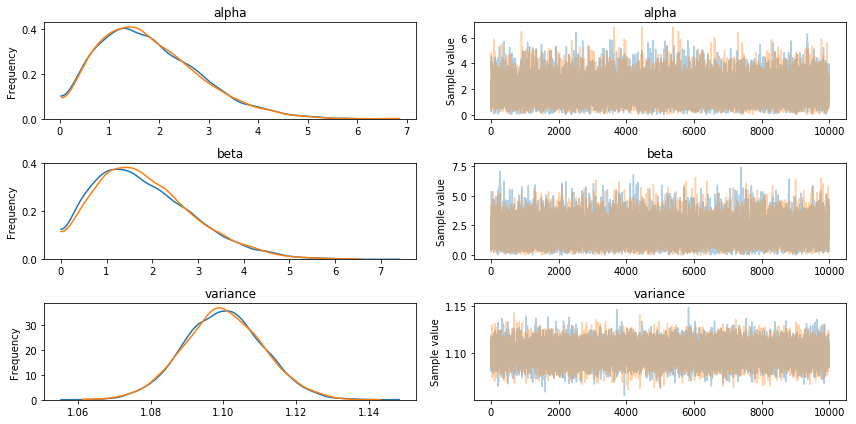

In [7]:
%matplotlib inline

nsamples = 10000
with model:
    trace = pymc3.sample(nsamples)
    pymc3.traceplot(trace)

In [12]:
print('Estimated Variance: ', np.mean(trace['variance']))
print('Ground Truth Variance: ', gtruthV)
print('Difference: ', np.mean(trace['variance']) - gtruthV)

Estimated Variance:  1.09996281585
Ground Truth Variance:  1.06998380122
Difference:  0.0299790146272


## Bibliography
- Wikipedia, [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution)
- Wikipedia, [Gamma Distribution](https://en.wikipedia.org/wiki/Gamma_distribution)
- Wikipedia, [Inverse Gaussian Distribution](https://en.wikipedia.org/wiki/Inverse-gamma_distribution)
- Wikipedia, [Conjugate Prior](https://en.wikipedia.org/wiki/Conjugate_prior)